In [9]:
#@title Step 1: Mount Google Drive and set up the environment
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your dataset folder in Google Drive.
# Make sure that inside this folder you have the sub-folders "Fresh", "Slightly Damaged", and "Heavily Damaged".
# Update the following path as necessary.
dataset_dir = '/content/drive/MyDrive/AI for Good Hackathon/Fruit Photos for FruitNinja'  # <-- change this to your folder path

# Print sub-folders (should show your 3 classes)
print("Found classes:", os.listdir(dataset_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found classes: ['Fresh', 'Slightly Damaged', 'Heavy Damage']


In [10]:
#@title Step 2: Create Training and Validation Datasets
# Define image parameters and batch size
img_height = 224
img_width = 224
batch_size = 16

# Use 80% of the data for training and 20% for validation.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,  # ensure shuffling is consistent between subsets
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Get class names (should be ["Fresh", "Heavily Damaged", "Slightly Damaged"] or similar, depending on alphabetical order)
print("Class names:", train_ds.class_names)

Found 154 files belonging to 3 classes.
Using 124 files for training.
Found 154 files belonging to 3 classes.
Using 30 files for validation.
Class names: ['Fresh', 'Heavy Damage', 'Slightly Damaged']


In [11]:
#@title Step 3: Set Up Data Augmentation and Performance Optimization
# Create a data augmentation pipeline.
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Optimize dataset performance with caching and prefetching.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
#@title Step 4: Build the Model with Transfer Learning (MobileNetV2)
# Load the pre-trained MobileNetV2 model, excluding the top classification layers.
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model for initial training

# Build the classification head on top of the base model.
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)  # Apply data augmentation
# Preprocess the inputs using MobileNetV2's preprocessing function.
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)  # Ensure the base model runs in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Regularization
# Final output layer with 3 classes; adjust the number of units if you have more/less classes.
outputs = layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs, outputs)

# Compile the model with an optimizer, loss, and metric.
model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',  # Note: our labels are integer encoded
              metrics=['accuracy'])

# Display the model architecture.
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_1 (Subtract)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
#@title Step 5: Train the Model
# Set the number of epochs. You can increase this number for improved performance (training time will increase).
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 752ms/step - accuracy: 0.8766 - loss: 0.3159 - val_accuracy: 0.9333 - val_loss: 0.3368
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9122 - loss: 0.2866 - val_accuracy: 0.9000 - val_loss: 0.3248
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 744ms/step - accuracy: 0.9183 - loss: 0.2406 - val_accuracy: 0.9000 - val_loss: 0.3358
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9187 - loss: 0.2257 - val_accuracy: 0.9000 - val_loss: 0.3021
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 748ms/step - accuracy: 0.9475 - loss: 0.1476 - val_accuracy: 0.9000 - val_loss: 0.2811
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9530 - loss: 0.1630 - val_accuracy: 0.9000 - val_loss: 0.2805
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 751ms/step - accuracy: 0.9717 - loss: 0.1131 - val_accuracy: 0.9000 - val_loss: 0.2771
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9707 - loss: 0.1364 - val_accuracy: 0.9000 - val_loss: 0.2760
Epoc

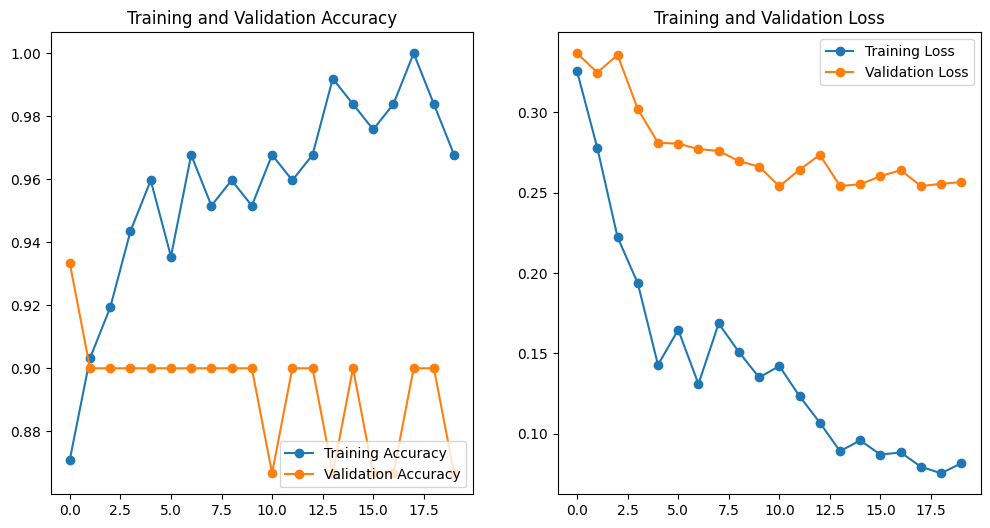

In [18]:
#@title Step 6: Visualize Training Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

# Plot training and validation accuracy.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
Confusion Matrix:
[[ 6  0  0]
 [ 0 12  1]
 [ 1  2  8]]


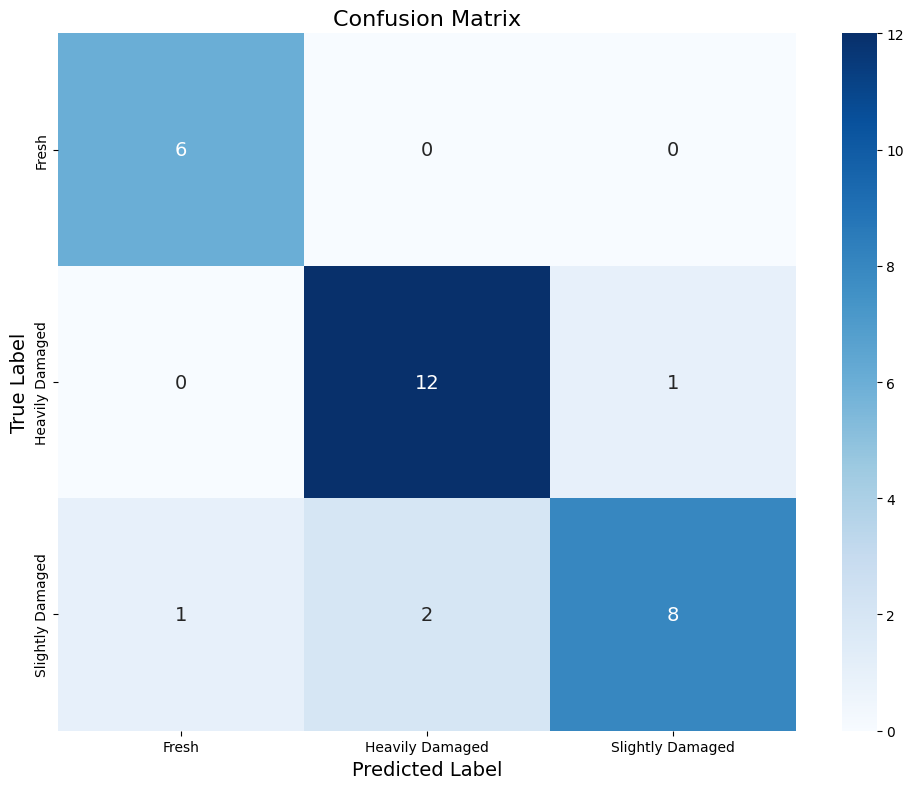


Classification Report:
                  precision    recall  f1-score   support

           Fresh       0.86      1.00      0.92         6
 Heavily Damaged       0.86      0.92      0.89        13
Slightly Damaged       0.89      0.73      0.80        11

        accuracy                           0.87        30
       macro avg       0.87      0.88      0.87        30
    weighted avg       0.87      0.87      0.86        30



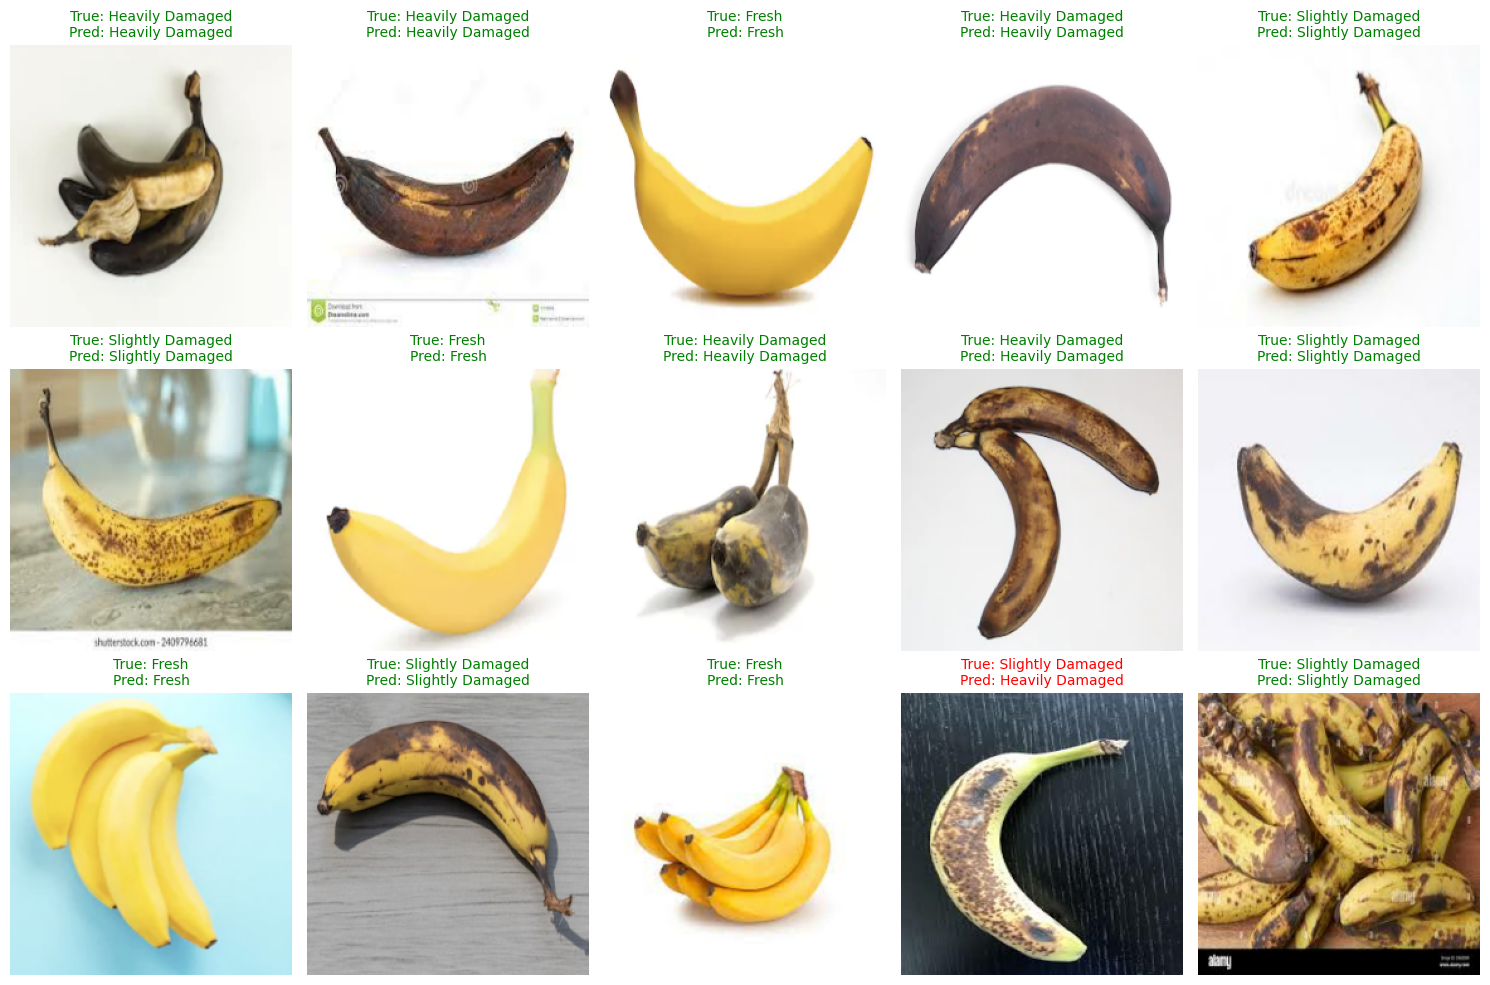

In [19]:
#@title Step X: Enhanced Evaluation and Visualization

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------------------------
# IMPORTANT: Since caching/prefetching removed the .class_names attribute,
# we store them here manually. Adjust the order if needed.
# For example, if your folders are "Fresh", "Slightly Damaged", "Heavily Damaged"
# and they are sorted alphabetically, you might need:
class_names = ['Fresh', 'Heavily Damaged', 'Slightly Damaged']

# ----------------------------------------------
# Collect true labels, predictions, and images from the validation dataset.
all_true_labels = []
all_pred_labels = []
all_images = []

for images, labels in val_ds:
    predictions = model.predict(images)
    preds = np.argmax(predictions, axis=1)
    all_true_labels.extend(labels.numpy())
    all_pred_labels.extend(preds)
    all_images.append(images.numpy())

# Concatenate all image batches into a single array
all_images = np.concatenate(all_images, axis=0)

# ----------------------------------------------
# Compute the Confusion Matrix
cm = confusion_matrix(all_true_labels, all_pred_labels)
print("Confusion Matrix:")
print(cm)

# Plot an enhanced, more presentable confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=True,
            annot_kws={"size": 14},
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.show()

# ----------------------------------------------
# Print a Classification Report for additional performance details
print("\nClassification Report:")
print(classification_report(all_true_labels, all_pred_labels, target_names=class_names))

# ----------------------------------------------
# Display a set of sample images with their true and predicted labels.
# Correct predictions are shown in green, incorrect ones in red.
num_samples = 15  # Adjust the number of images to display as needed.
plt.figure(figsize=(15, 10))
for i in range(num_samples):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(all_images[i].astype("uint8"))
    true_label = class_names[all_true_labels[i]]
    pred_label = class_names[all_pred_labels[i]]
    title_color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color, fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [20]:
#@title Step 7: Save the Trained Model
# Save the trained model to a file. This file can be uploaded to GitHub or used later.
model.save('/content/drive/MyDrive/AI for Good Hackathon/Fruit Photos for FruitNinja/FruitNinja.h5')
print("Model saved as FruitNinja.h5")

Model saved as FruitNinja.h5
